In [12]:
# from google.colab import drive
# drive.mount('/content/drive')

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torch import device
from tqdm.notebook import tqdm
torch.manual_seed(47)
np.random.seed(47)

from ResNet import ResNet18

In [14]:
class ResUnit(nn.Module):
    def __init__(self, p=64, stride=2,exp=1):
        super(ResUnit, self).__init__()
        self.c1 = nn.Conv2d(p, p*exp, kernel_size=3, stride=stride, padding=1, bias=False)
        self.b1 = nn.BatchNorm2d(p*exp)
        self.relu = nn.ReLU()
        self.c2 = nn.Conv2d( p*exp,  p*exp , kernel_size=3, stride=1, padding=1, bias=False)
        self.b2 = nn.BatchNorm2d( p*exp)
        self.drp = nn.Dropout(0.2)
        self.relu2 = nn.ReLU()

        ## to ensure same dimension
        self.residual = nn.Sequential()
        if stride != 1 or exp!=1:
            self.residual = nn.Sequential(
                nn.Conv2d( p, p*exp, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d( p*exp )
            )

    def forward(self, x):
        out = self.relu(self.b1(self.c1(x)))
        out = self.b2(self.c2(out))
        out = self.drp(out)
        res = self.residual(x)
        out = self.relu2(out+res)
        return out


class ResNet18(nn.Module):
    def __init__(self,p,expansion,num_classes=100):
        super(ResNet18, self).__init__()
        #input size is 32x32x3
        #first layer
        # to go from 32*32 to
        p=64
        l=[
            nn.Conv2d(3, p, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(p),
            nn.ReLU(inplace=True),
          ]
        l.append(ResUnit(p,  1))
        l.append(ResUnit(p,  1))

        l.append(ResUnit(p,  2,expansion))
        p*=expansion
        l.append(ResUnit(p,  1))

        l.append(ResUnit(p,  2,expansion))
        p*=expansion
        l.append(ResUnit(p,  1))

        l.append(ResUnit(p,  2,expansion))
        p*=expansion
        l.append(ResUnit(p,  1))

        l.extend([
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
        ])

        self.model = nn.Sequential(*l)
        self.cl=nn.Linear(p,num_classes)
    def forward(self, x):
        x = self.model(x)
        x = self.cl(x)
        return x

# Training the model

In [15]:
#hyperparameters
p=64
lr =0.01
batch_size = 32
epochs = 500
exp = 2
weight_decay = 5e-4
crit = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [16]:
resnet = ResNet18(p,2,100).to(device)
opti = torch.optim.SGD(resnet.parameters(), lr=lr, weight_decay=1e-6,momentum = 0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opti, T_max=epochs)

In [17]:
transf = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
])
tr = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

In [18]:
train_data = torchvision.datasets.CIFAR100(
    root="./data", train=True, download=True, transform=transf
)
val_data = torchvision.datasets.CIFAR100(
    root="./data", train=False, download=True, transform=tr
)

In [19]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [20]:
print(resnet)

ResNet18(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ResUnit(
      (c1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drp): Dropout(p=0.2, inplace=False)
      (relu2): ReLU()
      (residual): Sequential()
    )
    (4): ResUnit(
      (c1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (c2): Conv2d(64, 64, kernel_size

In [ ]:
def train(resnet,crit,opti,scheduler,train_dataloader,val_dataloader,epochs,save=True):
    resnet.train()
    losses = []
    accuracies = []
    val_losses = []
    val_accuracies = []
    tmp = []
    for epoch in range(epochs):
        i=0
        correct, total = 0, 0
        for inputs, labels in tqdm(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = resnet(inputs)

            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

            loss = crit(outputs, labels)
            tmp.append(loss.item())
            

            opti.zero_grad()
            loss.backward()
            opti.step()
            scheduler.step()


            i+=1
        losses.append(np.mean(tmp))
        accuracies.append(float(correct)/float(total))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(losses[-1])}, Accuracy: {accuracies[-1]}")
        tmp = []
        resnet.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for val_in,val_l in val_dataloader:
                val_in = val_in.to(device)
                val_l = val_l.to(device)

                val_out = resnet(val_in)

                val_loss = crit(val_out, val_l)

                val_correct += (val_out.argmax(dim=1) == val_l).sum().item()
                val_total += val_l.size(0)
        val_losses .append(val_loss.item())
        val_accuracies.append(float(val_correct)/float(val_total))
        print(f"Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracies[-1]}")

        if epoch % 10 == 0 and save:
            torch.save(resnet.state_dict(), f"./models/resnet_{epoch}_epoch.pth")

    return losses, accuracies, val_losses, val_accuracies


In [22]:
losses, accuracies, val_losses, val_accuracies = train(resnet,crit,opti,scheduler,train_dataloader,val_dataloader,epochs)

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1/500, Loss: 3.8922723228932954, Accuracy: 0.102
Validation Loss: 2.9134483337402344, Validation Accuracy: 0.2015


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2/500, Loss: 3.3757021630031514, Accuracy: 0.18022
Validation Loss: 3.190093994140625, Validation Accuracy: 0.1802


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3/500, Loss: 2.9058987172993804, Accuracy: 0.26546
Validation Loss: 2.7103610038757324, Validation Accuracy: 0.3099


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4/500, Loss: 2.6821386875133064, Accuracy: 0.30668
Validation Loss: 2.3498148918151855, Validation Accuracy: 0.3441


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5/500, Loss: 2.325519869515168, Accuracy: 0.3864
Validation Loss: 2.540154218673706, Validation Accuracy: 0.3706


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6/500, Loss: 2.2298165030458077, Accuracy: 0.40368
Validation Loss: 1.7125129699707031, Validation Accuracy: 0.4363


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7/500, Loss: 1.9752958366982234, Accuracy: 0.46312
Validation Loss: 1.7615000009536743, Validation Accuracy: 0.3859


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8/500, Loss: 1.892543351162113, Accuracy: 0.48114
Validation Loss: 1.618759036064148, Validation Accuracy: 0.4901


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9/500, Loss: 1.7430159038865864, Accuracy: 0.5179
Validation Loss: 1.4931949377059937, Validation Accuracy: 0.4271


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10/500, Loss: 1.6122172665153645, Accuracy: 0.54686
Validation Loss: 1.5159300565719604, Validation Accuracy: 0.5231


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11/500, Loss: 1.5649394665630827, Accuracy: 0.55852
Validation Loss: 2.0508811473846436, Validation Accuracy: 0.4839


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12/500, Loss: 1.3708872138424248, Accuracy: 0.60774
Validation Loss: 1.4065767526626587, Validation Accuracy: 0.5193


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 13/500, Loss: 1.3972222407277548, Accuracy: 0.60004
Validation Loss: 1.465656042098999, Validation Accuracy: 0.5248


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 14/500, Loss: 1.1989354142682032, Accuracy: 0.6543
Validation Loss: 1.7985608577728271, Validation Accuracy: 0.4938


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 15/500, Loss: 1.2095658590377178, Accuracy: 0.65214
Validation Loss: 1.6710020303726196, Validation Accuracy: 0.5581


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 16/500, Loss: 1.0798833079240449, Accuracy: 0.68536
Validation Loss: 2.0028891563415527, Validation Accuracy: 0.4942


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 17/500, Loss: 1.047545665094506, Accuracy: 0.69342
Validation Loss: 1.4899215698242188, Validation Accuracy: 0.5678


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 18/500, Loss: 0.9941483917750384, Accuracy: 0.70634
Validation Loss: 1.8044085502624512, Validation Accuracy: 0.527


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 19/500, Loss: 0.8646259586721831, Accuracy: 0.74524
Validation Loss: 1.5262486934661865, Validation Accuracy: 0.5536


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 20/500, Loss: 0.9010996559226048, Accuracy: 0.73326
Validation Loss: 1.1939231157302856, Validation Accuracy: 0.5425


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 21/500, Loss: 0.7375710619731508, Accuracy: 0.77964
Validation Loss: 1.2697867155075073, Validation Accuracy: 0.5291


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 22/500, Loss: 0.8034321468225749, Accuracy: 0.7588
Validation Loss: 1.3589774370193481, Validation Accuracy: 0.5598


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 23/500, Loss: 0.6686810477471703, Accuracy: 0.8002
Validation Loss: 1.1001181602478027, Validation Accuracy: 0.5235


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 24/500, Loss: 0.689243122782756, Accuracy: 0.79168
Validation Loss: 1.3941292762756348, Validation Accuracy: 0.5672


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 25/500, Loss: 0.6191745749218908, Accuracy: 0.81138
Validation Loss: 1.2358713150024414, Validation Accuracy: 0.4882


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 26/500, Loss: 0.5851792284619404, Accuracy: 0.82386
Validation Loss: 1.5764073133468628, Validation Accuracy: 0.5712


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 27/500, Loss: 0.5831099762768983, Accuracy: 0.82288
Validation Loss: 2.032925605773926, Validation Accuracy: 0.5379


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 28/500, Loss: 0.48621715935839727, Accuracy: 0.85296
Validation Loss: 1.6909666061401367, Validation Accuracy: 0.5596


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 29/500, Loss: 0.5306798438741203, Accuracy: 0.83728
Validation Loss: 2.0414249897003174, Validation Accuracy: 0.5527


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 30/500, Loss: 0.4221361238135219, Accuracy: 0.87118
Validation Loss: 1.9024596214294434, Validation Accuracy: 0.5358


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 31/500, Loss: 0.46750313124154064, Accuracy: 0.85582
Validation Loss: 1.7527042627334595, Validation Accuracy: 0.5628


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 32/500, Loss: 0.4002999019828731, Accuracy: 0.87702
Validation Loss: 2.024704933166504, Validation Accuracy: 0.5241


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 33/500, Loss: 0.39124326880780536, Accuracy: 0.88022
Validation Loss: 1.5177232027053833, Validation Accuracy: 0.5649


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 34/500, Loss: 0.38294484576785975, Accuracy: 0.88204
Validation Loss: 1.7139519453048706, Validation Accuracy: 0.5296


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 35/500, Loss: 0.33634290316392995, Accuracy: 0.89618
Validation Loss: 1.6927666664123535, Validation Accuracy: 0.5588


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 36/500, Loss: 0.36066541518784834, Accuracy: 0.8874
Validation Loss: 2.244616985321045, Validation Accuracy: 0.5447


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 37/500, Loss: 0.2924364907386989, Accuracy: 0.90888
Validation Loss: 1.8054579496383667, Validation Accuracy: 0.542


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 38/500, Loss: 0.3268403096538054, Accuracy: 0.89566
Validation Loss: 1.9211773872375488, Validation Accuracy: 0.5623


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 39/500, Loss: 0.2709162542685838, Accuracy: 0.91624
Validation Loss: 1.710721731185913, Validation Accuracy: 0.5306


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 40/500, Loss: 0.28731411059940576, Accuracy: 0.90896
Validation Loss: 1.6786363124847412, Validation Accuracy: 0.5558


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 41/500, Loss: 0.2577259659758809, Accuracy: 0.91958
Validation Loss: 2.47135329246521, Validation Accuracy: 0.5306


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 42/500, Loss: 0.23400849505772747, Accuracy: 0.92606
Validation Loss: 2.262571334838867, Validation Accuracy: 0.5662


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 43/500, Loss: 0.24763033728538913, Accuracy: 0.92024
Validation Loss: 2.573578357696533, Validation Accuracy: 0.5368


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 44/500, Loss: 0.20923833268493777, Accuracy: 0.93338
Validation Loss: 1.574402093887329, Validation Accuracy: 0.5574


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 45/500, Loss: 0.2388137147981752, Accuracy: 0.92456
Validation Loss: 1.472385287284851, Validation Accuracy: 0.555


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 46/500, Loss: 0.1870747906805665, Accuracy: 0.93988
Validation Loss: 1.7737692594528198, Validation Accuracy: 0.5371


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 47/500, Loss: 0.20925935996387698, Accuracy: 0.93326
Validation Loss: 1.8698949813842773, Validation Accuracy: 0.5626


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 48/500, Loss: 0.18472236901210645, Accuracy: 0.94184
Validation Loss: 2.099714517593384, Validation Accuracy: 0.5265


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 49/500, Loss: 0.18935602104502253, Accuracy: 0.9398
Validation Loss: 1.9634610414505005, Validation Accuracy: 0.5602


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 50/500, Loss: 0.18347572111265445, Accuracy: 0.94324
Validation Loss: 1.7716553211212158, Validation Accuracy: 0.5338


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 51/500, Loss: 0.15823848911913221, Accuracy: 0.9497
Validation Loss: 1.5822138786315918, Validation Accuracy: 0.5623


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 52/500, Loss: 0.17808984094227873, Accuracy: 0.94338
Validation Loss: 1.7705739736557007, Validation Accuracy: 0.5554


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 53/500, Loss: 0.13861745987230495, Accuracy: 0.9558
Validation Loss: 1.8556137084960938, Validation Accuracy: 0.5442


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 54/500, Loss: 0.16787463344421455, Accuracy: 0.94578
Validation Loss: 1.9651895761489868, Validation Accuracy: 0.5593


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 55/500, Loss: 0.12842156377475605, Accuracy: 0.95916
Validation Loss: 2.1888136863708496, Validation Accuracy: 0.5281


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 56/500, Loss: 0.14578936124454067, Accuracy: 0.95486
Validation Loss: 2.1256980895996094, Validation Accuracy: 0.5628


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 57/500, Loss: 0.13946895792207997, Accuracy: 0.95662
Validation Loss: 1.9945871829986572, Validation Accuracy: 0.5282


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 58/500, Loss: 0.12943397506383134, Accuracy: 0.9581
Validation Loss: 2.437643051147461, Validation Accuracy: 0.5676


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 59/500, Loss: 0.13317891098304174, Accuracy: 0.95848
Validation Loss: 2.339672803878784, Validation Accuracy: 0.5512


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 60/500, Loss: 0.10939908764171352, Accuracy: 0.96516
Validation Loss: 2.3905675411224365, Validation Accuracy: 0.5547


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 61/500, Loss: 0.13028102603851818, Accuracy: 0.9585
Validation Loss: 2.077489137649536, Validation Accuracy: 0.5634


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 62/500, Loss: 0.09823754455837476, Accuracy: 0.96958
Validation Loss: 2.261392593383789, Validation Accuracy: 0.5428


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 63/500, Loss: 0.11881632876677185, Accuracy: 0.96222
Validation Loss: 2.2845702171325684, Validation Accuracy: 0.5629


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 64/500, Loss: 0.09745270589573467, Accuracy: 0.96926
Validation Loss: 2.1669256687164307, Validation Accuracy: 0.5388


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 65/500, Loss: 0.10116104808657163, Accuracy: 0.96844
Validation Loss: 2.31355357170105, Validation Accuracy: 0.5659


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 66/500, Loss: 0.09971598325986493, Accuracy: 0.9679
Validation Loss: 2.320647716522217, Validation Accuracy: 0.5415


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 67/500, Loss: 0.08844627814482264, Accuracy: 0.9723
Validation Loss: 2.4699783325195312, Validation Accuracy: 0.5695


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 68/500, Loss: 0.10163716241168853, Accuracy: 0.96774
Validation Loss: 2.100470542907715, Validation Accuracy: 0.5585


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 69/500, Loss: 0.07403210482311849, Accuracy: 0.97656
Validation Loss: 1.8225741386413574, Validation Accuracy: 0.5556


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 70/500, Loss: 0.09996175455967451, Accuracy: 0.9679
Validation Loss: 2.863776206970215, Validation Accuracy: 0.5656


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 71/500, Loss: 0.07285523570167414, Accuracy: 0.9765
Validation Loss: 2.7883267402648926, Validation Accuracy: 0.5408


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 72/500, Loss: 0.08518269724359018, Accuracy: 0.97334
Validation Loss: 2.704087972640991, Validation Accuracy: 0.5692


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 73/500, Loss: 0.08391428930999685, Accuracy: 0.9739
Validation Loss: 2.2978665828704834, Validation Accuracy: 0.5349


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 74/500, Loss: 0.08083414220294641, Accuracy: 0.9752
Validation Loss: 2.5430867671966553, Validation Accuracy: 0.5692


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 75/500, Loss: 0.08122606811500067, Accuracy: 0.97492
Validation Loss: 2.2664361000061035, Validation Accuracy: 0.5497


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 76/500, Loss: 0.06405862165871627, Accuracy: 0.97998
Validation Loss: 1.7625542879104614, Validation Accuracy: 0.5731


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 77/500, Loss: 0.08784019298705059, Accuracy: 0.97186
Validation Loss: 1.5700331926345825, Validation Accuracy: 0.5667


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 78/500, Loss: 0.0681773799666551, Accuracy: 0.9784
Validation Loss: 2.320110559463501, Validation Accuracy: 0.5523


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 79/500, Loss: 0.07391071845512177, Accuracy: 0.97672
Validation Loss: 2.54219388961792, Validation Accuracy: 0.5694


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 80/500, Loss: 0.0656545828311449, Accuracy: 0.97882
Validation Loss: 2.285679578781128, Validation Accuracy: 0.5397


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 81/500, Loss: 0.07026588525018289, Accuracy: 0.97722
Validation Loss: 1.8201353549957275, Validation Accuracy: 0.5699


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 82/500, Loss: 0.06868155813935795, Accuracy: 0.97722
Validation Loss: 1.9249027967453003, Validation Accuracy: 0.5397


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 83/500, Loss: 0.05852093526624796, Accuracy: 0.98162
Validation Loss: 2.1909167766571045, Validation Accuracy: 0.5669


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 84/500, Loss: 0.07113119741494786, Accuracy: 0.97668
Validation Loss: 2.2701640129089355, Validation Accuracy: 0.5583


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 85/500, Loss: 0.053487051400177316, Accuracy: 0.98346
Validation Loss: 2.1142704486846924, Validation Accuracy: 0.5635


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 86/500, Loss: 0.065210508954036, Accuracy: 0.9796
Validation Loss: 1.9440593719482422, Validation Accuracy: 0.5676


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 87/500, Loss: 0.05603118140416688, Accuracy: 0.98244
Validation Loss: 2.971675157546997, Validation Accuracy: 0.5484


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 88/500, Loss: 0.060756244968740755, Accuracy: 0.97992
Validation Loss: 1.9897613525390625, Validation Accuracy: 0.5679


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 89/500, Loss: 0.056383862119162534, Accuracy: 0.98162
Validation Loss: 2.5948538780212402, Validation Accuracy: 0.5438


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 90/500, Loss: 0.05490591974231228, Accuracy: 0.98288
Validation Loss: 1.9829915761947632, Validation Accuracy: 0.5702


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 91/500, Loss: 0.06036752200631368, Accuracy: 0.98058
Validation Loss: 1.9964120388031006, Validation Accuracy: 0.55


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 92/500, Loss: 0.046087890601819274, Accuracy: 0.98586
Validation Loss: 1.6510450839996338, Validation Accuracy: 0.5661


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 93/500, Loss: 0.06517244740104766, Accuracy: 0.9796
Validation Loss: 1.8701114654541016, Validation Accuracy: 0.5588


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 94/500, Loss: 0.04325651586471291, Accuracy: 0.98632
Validation Loss: 2.058380126953125, Validation Accuracy: 0.5612


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 95/500, Loss: 0.06190250899985844, Accuracy: 0.98022
Validation Loss: 2.3010854721069336, Validation Accuracy: 0.5681


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 96/500, Loss: 0.04363323533965815, Accuracy: 0.98688
Validation Loss: 2.2229373455047607, Validation Accuracy: 0.5596


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 97/500, Loss: 0.04821161576594211, Accuracy: 0.9845
Validation Loss: 2.106577157974243, Validation Accuracy: 0.5665


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 98/500, Loss: 0.05095902975724129, Accuracy: 0.98428
Validation Loss: 1.965548038482666, Validation Accuracy: 0.5545


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 99/500, Loss: 0.04142048749960901, Accuracy: 0.9869
Validation Loss: 2.0089292526245117, Validation Accuracy: 0.5701


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 100/500, Loss: 0.052046457791675785, Accuracy: 0.984
Validation Loss: 2.4279770851135254, Validation Accuracy: 0.5647


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 101/500, Loss: 0.04445855055058712, Accuracy: 0.98642
Validation Loss: 1.8086622953414917, Validation Accuracy: 0.5637


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 102/500, Loss: 0.04362353004547487, Accuracy: 0.98604
Validation Loss: 2.4717891216278076, Validation Accuracy: 0.5661


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 103/500, Loss: 0.03368006632851423, Accuracy: 0.98928
Validation Loss: 2.639949083328247, Validation Accuracy: 0.5538


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 104/500, Loss: 0.04378987107199429, Accuracy: 0.98676
Validation Loss: 2.4094815254211426, Validation Accuracy: 0.563


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 105/500, Loss: 0.044266471465183255, Accuracy: 0.98656
Validation Loss: 2.695098638534546, Validation Accuracy: 0.5494


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 106/500, Loss: 0.04468167700364544, Accuracy: 0.98596
Validation Loss: 2.234529733657837, Validation Accuracy: 0.5658


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 107/500, Loss: 0.04008296988181629, Accuracy: 0.98814
Validation Loss: 2.5031991004943848, Validation Accuracy: 0.5557


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 108/500, Loss: 0.03299215330900956, Accuracy: 0.98956
Validation Loss: 2.0317111015319824, Validation Accuracy: 0.572


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 109/500, Loss: 0.040247079042862274, Accuracy: 0.98832
Validation Loss: 2.1252899169921875, Validation Accuracy: 0.5625


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 110/500, Loss: 0.03549255673601794, Accuracy: 0.98868
Validation Loss: 1.9179927110671997, Validation Accuracy: 0.56


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 111/500, Loss: 0.03578832633475549, Accuracy: 0.98854
Validation Loss: 2.398906707763672, Validation Accuracy: 0.571


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 112/500, Loss: 0.036253011417603835, Accuracy: 0.98846
Validation Loss: 1.5474507808685303, Validation Accuracy: 0.5437


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 113/500, Loss: 0.0393089151479163, Accuracy: 0.98788
Validation Loss: 1.7837843894958496, Validation Accuracy: 0.5698


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 114/500, Loss: 0.036296134989354724, Accuracy: 0.98864
Validation Loss: 2.4492664337158203, Validation Accuracy: 0.558


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 115/500, Loss: 0.02799789267496516, Accuracy: 0.99122
Validation Loss: 2.6239333152770996, Validation Accuracy: 0.5687


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 116/500, Loss: 0.04242424955469874, Accuracy: 0.98676
Validation Loss: 2.364546298980713, Validation Accuracy: 0.5656


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 117/500, Loss: 0.026124885976314172, Accuracy: 0.99212
Validation Loss: 2.7976133823394775, Validation Accuracy: 0.5661


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 118/500, Loss: 0.034337068600711, Accuracy: 0.98916
Validation Loss: 2.3129804134368896, Validation Accuracy: 0.5659


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 119/500, Loss: 0.033016423587619165, Accuracy: 0.99016
Validation Loss: 2.273574113845825, Validation Accuracy: 0.5509


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 120/500, Loss: 0.03164704277684974, Accuracy: 0.99036
Validation Loss: 2.1460161209106445, Validation Accuracy: 0.5717


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 121/500, Loss: 0.028369485276844377, Accuracy: 0.99108
Validation Loss: 2.62744140625, Validation Accuracy: 0.5546


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 122/500, Loss: 0.030566075917502523, Accuracy: 0.99026
Validation Loss: 2.7813475131988525, Validation Accuracy: 0.5699


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 123/500, Loss: 0.03280385345432765, Accuracy: 0.98946
Validation Loss: 2.352874279022217, Validation Accuracy: 0.5627


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 124/500, Loss: 0.02626314552586652, Accuracy: 0.99196
Validation Loss: 1.8070380687713623, Validation Accuracy: 0.5733


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 125/500, Loss: 0.03325198351148356, Accuracy: 0.98998
Validation Loss: 2.24853777885437, Validation Accuracy: 0.5665


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 126/500, Loss: 0.021645148103013576, Accuracy: 0.99366
Validation Loss: 1.9672471284866333, Validation Accuracy: 0.5733


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 127/500, Loss: 0.022050127000443485, Accuracy: 0.9929
Validation Loss: 2.7439558506011963, Validation Accuracy: 0.5683


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 128/500, Loss: 0.022191256258496092, Accuracy: 0.99308
Validation Loss: 2.5283730030059814, Validation Accuracy: 0.5545


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 129/500, Loss: 0.029682231479261016, Accuracy: 0.99116
Validation Loss: 2.4611260890960693, Validation Accuracy: 0.5664


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 130/500, Loss: 0.025008661396497465, Accuracy: 0.9925
Validation Loss: 2.6571738719940186, Validation Accuracy: 0.5671


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 131/500, Loss: 0.02153144355311773, Accuracy: 0.99378
Validation Loss: 2.553683280944824, Validation Accuracy: 0.5726


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 132/500, Loss: 0.030174191224229936, Accuracy: 0.99036
Validation Loss: 1.9918711185455322, Validation Accuracy: 0.5662


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 133/500, Loss: 0.024054822104380043, Accuracy: 0.99246
Validation Loss: 1.647040843963623, Validation Accuracy: 0.5705


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 134/500, Loss: 0.023901834385466645, Accuracy: 0.99276
Validation Loss: 2.676600933074951, Validation Accuracy: 0.5702


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 135/500, Loss: 0.01909155281362971, Accuracy: 0.99404
Validation Loss: 3.137016534805298, Validation Accuracy: 0.5647


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 136/500, Loss: 0.026507413924631427, Accuracy: 0.992
Validation Loss: 1.5672146081924438, Validation Accuracy: 0.5716


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 137/500, Loss: 0.020836869307474692, Accuracy: 0.99412
Validation Loss: 2.0111942291259766, Validation Accuracy: 0.5654


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 138/500, Loss: 0.01825450121760368, Accuracy: 0.99498
Validation Loss: 2.012106418609619, Validation Accuracy: 0.5687


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 139/500, Loss: 0.02016072486410835, Accuracy: 0.99382
Validation Loss: 2.7822110652923584, Validation Accuracy: 0.5707


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 140/500, Loss: 0.014275377559130675, Accuracy: 0.99554
Validation Loss: 2.8199119567871094, Validation Accuracy: 0.5783


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 141/500, Loss: 0.018596563381106185, Accuracy: 0.99484
Validation Loss: 2.207789897918701, Validation Accuracy: 0.579


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 142/500, Loss: 0.016530144052633353, Accuracy: 0.99554
Validation Loss: 2.6398119926452637, Validation Accuracy: 0.5711


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 143/500, Loss: 0.026569039967885608, Accuracy: 0.99234
Validation Loss: 3.0648632049560547, Validation Accuracy: 0.5665


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 144/500, Loss: 0.020901215494210326, Accuracy: 0.99368
Validation Loss: 2.9744365215301514, Validation Accuracy: 0.5573


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 145/500, Loss: 0.02474342200212579, Accuracy: 0.99234
Validation Loss: 2.448763370513916, Validation Accuracy: 0.5752


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 146/500, Loss: 0.02353849769129303, Accuracy: 0.99262
Validation Loss: 2.243434429168701, Validation Accuracy: 0.5664


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 147/500, Loss: 0.019945417975639847, Accuracy: 0.9943
Validation Loss: 1.9835624694824219, Validation Accuracy: 0.5767


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 148/500, Loss: 0.021804179868147724, Accuracy: 0.9932
Validation Loss: 2.7450616359710693, Validation Accuracy: 0.5633


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 149/500, Loss: 0.01660732460961371, Accuracy: 0.99464
Validation Loss: 2.3646833896636963, Validation Accuracy: 0.5741


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 150/500, Loss: 0.019552472009432345, Accuracy: 0.99386
Validation Loss: 2.8423163890838623, Validation Accuracy: 0.57


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 151/500, Loss: 0.01405694785927355, Accuracy: 0.99552
Validation Loss: 3.394784450531006, Validation Accuracy: 0.5688


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 152/500, Loss: 0.01950313603866653, Accuracy: 0.99364
Validation Loss: 3.352224349975586, Validation Accuracy: 0.5658


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 153/500, Loss: 0.021239166721982446, Accuracy: 0.99338
Validation Loss: 2.046635627746582, Validation Accuracy: 0.556


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 154/500, Loss: 0.02443044127643599, Accuracy: 0.99278
Validation Loss: 2.301009178161621, Validation Accuracy: 0.5675


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 155/500, Loss: 0.02328987583105403, Accuracy: 0.99316
Validation Loss: 2.5014705657958984, Validation Accuracy: 0.5593


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 156/500, Loss: 0.01969431980159396, Accuracy: 0.99406
Validation Loss: 2.6764514446258545, Validation Accuracy: 0.5693


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 157/500, Loss: 0.018865796436963518, Accuracy: 0.99444
Validation Loss: 2.056600570678711, Validation Accuracy: 0.567


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 158/500, Loss: 0.01524751864033583, Accuracy: 0.995
Validation Loss: 2.469135046005249, Validation Accuracy: 0.565


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 159/500, Loss: 0.01495862306490733, Accuracy: 0.99514
Validation Loss: 2.7225661277770996, Validation Accuracy: 0.5645


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 160/500, Loss: 0.019502713439633935, Accuracy: 0.99408
Validation Loss: 2.3774197101593018, Validation Accuracy: 0.5532


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 161/500, Loss: 0.02625209671960541, Accuracy: 0.99216
Validation Loss: 2.0237479209899902, Validation Accuracy: 0.5683


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 162/500, Loss: 0.026767795209379507, Accuracy: 0.99208
Validation Loss: 2.9329986572265625, Validation Accuracy: 0.5587


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 163/500, Loss: 0.019020940892688597, Accuracy: 0.99386
Validation Loss: 2.1611571311950684, Validation Accuracy: 0.5742


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 164/500, Loss: 0.024028214634716986, Accuracy: 0.9928
Validation Loss: 2.1454997062683105, Validation Accuracy: 0.57


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 165/500, Loss: 0.01297293730494066, Accuracy: 0.99624
Validation Loss: 2.8884923458099365, Validation Accuracy: 0.5721


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 166/500, Loss: 0.017481318252807885, Accuracy: 0.99512
Validation Loss: 3.015540599822998, Validation Accuracy: 0.5686


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 167/500, Loss: 0.015686591241072825, Accuracy: 0.99494
Validation Loss: 2.52374529838562, Validation Accuracy: 0.5572


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 168/500, Loss: 0.016827601696578067, Accuracy: 0.99476
Validation Loss: 2.572662115097046, Validation Accuracy: 0.5725


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 169/500, Loss: 0.020008410660481164, Accuracy: 0.99372
Validation Loss: 2.273400068283081, Validation Accuracy: 0.5482


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 170/500, Loss: 0.018389186582645937, Accuracy: 0.99434
Validation Loss: 2.203368663787842, Validation Accuracy: 0.568


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 171/500, Loss: 0.01856969987079552, Accuracy: 0.99446
Validation Loss: 3.0521535873413086, Validation Accuracy: 0.564


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 172/500, Loss: 0.018941603390066272, Accuracy: 0.99426
Validation Loss: 2.706339120864868, Validation Accuracy: 0.5724


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 173/500, Loss: 0.015243222149688996, Accuracy: 0.99532
Validation Loss: 2.4282124042510986, Validation Accuracy: 0.5736


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 174/500, Loss: 0.016603662484440337, Accuracy: 0.9949
Validation Loss: 2.8543834686279297, Validation Accuracy: 0.5668


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 175/500, Loss: 0.0196795538506371, Accuracy: 0.99356
Validation Loss: 2.1088695526123047, Validation Accuracy: 0.569


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 176/500, Loss: 0.013688253564534781, Accuracy: 0.99576
Validation Loss: 2.5067007541656494, Validation Accuracy: 0.5695


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 177/500, Loss: 0.01389642702041427, Accuracy: 0.99584
Validation Loss: 2.671255111694336, Validation Accuracy: 0.5784


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 178/500, Loss: 0.018161808258390654, Accuracy: 0.99432
Validation Loss: 2.2436931133270264, Validation Accuracy: 0.5639


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 179/500, Loss: 0.013814181004611958, Accuracy: 0.99584
Validation Loss: 1.840620994567871, Validation Accuracy: 0.5754


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 180/500, Loss: 0.014982268318878758, Accuracy: 0.9953
Validation Loss: 2.0470356941223145, Validation Accuracy: 0.5745


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 181/500, Loss: 0.01227656086089827, Accuracy: 0.99618
Validation Loss: 2.1769065856933594, Validation Accuracy: 0.569


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 182/500, Loss: 0.012175445379788746, Accuracy: 0.99624
Validation Loss: 1.9904074668884277, Validation Accuracy: 0.5719


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 183/500, Loss: 0.011661740526883393, Accuracy: 0.996
Validation Loss: 2.274005651473999, Validation Accuracy: 0.5626


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 184/500, Loss: 0.014023589251116861, Accuracy: 0.9956
Validation Loss: 1.684909462928772, Validation Accuracy: 0.5728


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 185/500, Loss: 0.01725453429237668, Accuracy: 0.99484
Validation Loss: 2.254258632659912, Validation Accuracy: 0.5565


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 186/500, Loss: 0.01458788012532913, Accuracy: 0.99554
Validation Loss: 2.2985825538635254, Validation Accuracy: 0.5717


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 187/500, Loss: 0.016903462028829856, Accuracy: 0.99492
Validation Loss: 2.1984496116638184, Validation Accuracy: 0.5639


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 188/500, Loss: 0.014396484788089988, Accuracy: 0.99564
Validation Loss: 2.342371702194214, Validation Accuracy: 0.5686


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 189/500, Loss: 0.019935015539536947, Accuracy: 0.99358
Validation Loss: 2.293191432952881, Validation Accuracy: 0.5776


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 190/500, Loss: 0.012106122763779696, Accuracy: 0.99618
Validation Loss: 1.7395570278167725, Validation Accuracy: 0.5753


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 191/500, Loss: 0.01136177392933766, Accuracy: 0.99684
Validation Loss: 1.8374865055084229, Validation Accuracy: 0.5788


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 192/500, Loss: 0.009688425427021764, Accuracy: 0.9972
Validation Loss: 2.07222318649292, Validation Accuracy: 0.5716


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 193/500, Loss: 0.012970682791091094, Accuracy: 0.99602
Validation Loss: 2.276181697845459, Validation Accuracy: 0.5755


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 194/500, Loss: 0.013085979504157684, Accuracy: 0.9963
Validation Loss: 1.6616030931472778, Validation Accuracy: 0.5658


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 195/500, Loss: 0.015140693268390843, Accuracy: 0.99536
Validation Loss: 1.6208630800247192, Validation Accuracy: 0.5713


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 196/500, Loss: 0.014559950276163731, Accuracy: 0.99546
Validation Loss: 2.1896681785583496, Validation Accuracy: 0.5689


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 197/500, Loss: 0.009867378056959048, Accuracy: 0.99676
Validation Loss: 2.177016019821167, Validation Accuracy: 0.5756


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 198/500, Loss: 0.016278910043789462, Accuracy: 0.99496
Validation Loss: 1.803439974784851, Validation Accuracy: 0.5679


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 199/500, Loss: 0.016255617415124258, Accuracy: 0.99506
Validation Loss: 1.9751673936843872, Validation Accuracy: 0.5621


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 200/500, Loss: 0.015886426820708677, Accuracy: 0.9953
Validation Loss: 2.1573169231414795, Validation Accuracy: 0.5735


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 201/500, Loss: 0.011408524623470069, Accuracy: 0.99644
Validation Loss: 1.8557803630828857, Validation Accuracy: 0.5657


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 202/500, Loss: 0.009616485501987546, Accuracy: 0.99716
Validation Loss: 2.25520396232605, Validation Accuracy: 0.5712


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 203/500, Loss: 0.008971901647928125, Accuracy: 0.99722
Validation Loss: 1.9116764068603516, Validation Accuracy: 0.5674


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 204/500, Loss: 0.009861218219448398, Accuracy: 0.99724
Validation Loss: 1.8514111042022705, Validation Accuracy: 0.5784


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 205/500, Loss: 0.012916179691463416, Accuracy: 0.99618
Validation Loss: 2.1245627403259277, Validation Accuracy: 0.5701


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 206/500, Loss: 0.011094490912275127, Accuracy: 0.99638
Validation Loss: 1.6657487154006958, Validation Accuracy: 0.5696


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 207/500, Loss: 0.011922416616484256, Accuracy: 0.9964
Validation Loss: 1.7626864910125732, Validation Accuracy: 0.5708


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 208/500, Loss: 0.011723453129013349, Accuracy: 0.99684
Validation Loss: 1.6308152675628662, Validation Accuracy: 0.5623


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 209/500, Loss: 0.013559502799125475, Accuracy: 0.9957
Validation Loss: 1.9275803565979004, Validation Accuracy: 0.5696


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 210/500, Loss: 0.012810644331209632, Accuracy: 0.99622
Validation Loss: 1.8429287672042847, Validation Accuracy: 0.5632


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 211/500, Loss: 0.009047543280448834, Accuracy: 0.99732
Validation Loss: 1.9406737089157104, Validation Accuracy: 0.5746


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 212/500, Loss: 0.017346668032939522, Accuracy: 0.99414
Validation Loss: 2.0035951137542725, Validation Accuracy: 0.5704


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 213/500, Loss: 0.007470031390238897, Accuracy: 0.99774
Validation Loss: 2.237816333770752, Validation Accuracy: 0.5699


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 214/500, Loss: 0.008942077812287, Accuracy: 0.99746
Validation Loss: 1.9008156061172485, Validation Accuracy: 0.5728


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 215/500, Loss: 0.011525544134629754, Accuracy: 0.99668
Validation Loss: 2.5314431190490723, Validation Accuracy: 0.5678


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 216/500, Loss: 0.014292067957916385, Accuracy: 0.99582
Validation Loss: 2.228626012802124, Validation Accuracy: 0.5688


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 217/500, Loss: 0.011798265882830743, Accuracy: 0.99684
Validation Loss: 2.518808364868164, Validation Accuracy: 0.5635


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 218/500, Loss: 0.009930649649760662, Accuracy: 0.99736
Validation Loss: 1.4981745481491089, Validation Accuracy: 0.5764


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 219/500, Loss: 0.01283160202251638, Accuracy: 0.99596
Validation Loss: 1.441765546798706, Validation Accuracy: 0.5731


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 220/500, Loss: 0.007773346597386972, Accuracy: 0.998
Validation Loss: 1.845924973487854, Validation Accuracy: 0.5748


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 221/500, Loss: 0.006269819112339444, Accuracy: 0.99826
Validation Loss: 2.109222888946533, Validation Accuracy: 0.5758


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 222/500, Loss: 0.006153815657110337, Accuracy: 0.99828
Validation Loss: 2.305746078491211, Validation Accuracy: 0.5734


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 223/500, Loss: 0.010003542300454159, Accuracy: 0.99666
Validation Loss: 1.4824531078338623, Validation Accuracy: 0.5754


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 224/500, Loss: 0.01190147243976326, Accuracy: 0.99682
Validation Loss: 2.1693856716156006, Validation Accuracy: 0.5575


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 225/500, Loss: 0.010564907141834026, Accuracy: 0.9967
Validation Loss: 1.9935609102249146, Validation Accuracy: 0.5782


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 226/500, Loss: 0.012363672575454773, Accuracy: 0.9961
Validation Loss: 1.533363699913025, Validation Accuracy: 0.5674


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 227/500, Loss: 0.010873511054126789, Accuracy: 0.99676
Validation Loss: 1.9494194984436035, Validation Accuracy: 0.5745


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 228/500, Loss: 0.012410676789583385, Accuracy: 0.996
Validation Loss: 1.9640326499938965, Validation Accuracy: 0.5772


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 229/500, Loss: 0.007813785302491877, Accuracy: 0.99774
Validation Loss: 2.3928945064544678, Validation Accuracy: 0.5759


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 230/500, Loss: 0.00581274946336887, Accuracy: 0.99812
Validation Loss: 3.2022225856781006, Validation Accuracy: 0.5762


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 231/500, Loss: 0.008901302719737082, Accuracy: 0.99696
Validation Loss: 3.025221347808838, Validation Accuracy: 0.5732


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 232/500, Loss: 0.011708688761885001, Accuracy: 0.99642
Validation Loss: 2.1433041095733643, Validation Accuracy: 0.5735


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 233/500, Loss: 0.009401177525475637, Accuracy: 0.9974
Validation Loss: 2.1388673782348633, Validation Accuracy: 0.571


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 234/500, Loss: 0.007989387738790942, Accuracy: 0.99748
Validation Loss: 1.7181442975997925, Validation Accuracy: 0.5767


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 235/500, Loss: 0.011225115120780414, Accuracy: 0.9962
Validation Loss: 1.250454068183899, Validation Accuracy: 0.5681


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 236/500, Loss: 0.005633277767446474, Accuracy: 0.99846
Validation Loss: 1.7679846286773682, Validation Accuracy: 0.5803


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 237/500, Loss: 0.012845286032154993, Accuracy: 0.99592
Validation Loss: 1.9461731910705566, Validation Accuracy: 0.5743


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 238/500, Loss: 0.011510927316559524, Accuracy: 0.9966
Validation Loss: 1.8004223108291626, Validation Accuracy: 0.5661


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 239/500, Loss: 0.010800906025322698, Accuracy: 0.99686
Validation Loss: 2.048736333847046, Validation Accuracy: 0.5719


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 240/500, Loss: 0.008377165928601374, Accuracy: 0.99734
Validation Loss: 1.8670469522476196, Validation Accuracy: 0.5702


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 241/500, Loss: 0.006103268744911192, Accuracy: 0.99812
Validation Loss: 1.5050486326217651, Validation Accuracy: 0.5755


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 242/500, Loss: 0.004486019982840206, Accuracy: 0.99876
Validation Loss: 1.7356678247451782, Validation Accuracy: 0.5779


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 243/500, Loss: 0.0038600964843921097, Accuracy: 0.99906
Validation Loss: 1.5527138710021973, Validation Accuracy: 0.58


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 244/500, Loss: 0.002675461108166174, Accuracy: 0.99922
Validation Loss: 1.843953251838684, Validation Accuracy: 0.5805


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 245/500, Loss: 0.0025389066138632463, Accuracy: 0.99936
Validation Loss: 2.166689157485962, Validation Accuracy: 0.5798


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 246/500, Loss: 0.002652753600221002, Accuracy: 0.9994
Validation Loss: 1.8533434867858887, Validation Accuracy: 0.5818


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 247/500, Loss: 0.0016101263777619059, Accuracy: 0.99956
Validation Loss: 2.064004898071289, Validation Accuracy: 0.5832


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 248/500, Loss: 0.0023861039422356204, Accuracy: 0.99938
Validation Loss: 2.1158719062805176, Validation Accuracy: 0.58


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 249/500, Loss: 0.0027976288302551788, Accuracy: 0.9995
Validation Loss: 2.0871992111206055, Validation Accuracy: 0.579


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 250/500, Loss: 0.0029140457428827224, Accuracy: 0.99924
Validation Loss: 1.6154104471206665, Validation Accuracy: 0.5813


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 251/500, Loss: 0.002429369858019291, Accuracy: 0.99944
Validation Loss: 1.9545323848724365, Validation Accuracy: 0.5827


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 252/500, Loss: 0.001662822367301553, Accuracy: 0.9997
Validation Loss: 2.0501880645751953, Validation Accuracy: 0.5833


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 253/500, Loss: 0.0028144366055527443, Accuracy: 0.99922
Validation Loss: 1.4877732992172241, Validation Accuracy: 0.5812


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 254/500, Loss: 0.0023030387964157843, Accuracy: 0.99936
Validation Loss: 1.6897873878479004, Validation Accuracy: 0.5858


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 255/500, Loss: 0.002565587701135598, Accuracy: 0.99934
Validation Loss: 1.9418176412582397, Validation Accuracy: 0.5825


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 256/500, Loss: 0.002328741566927615, Accuracy: 0.9994
Validation Loss: 1.8892979621887207, Validation Accuracy: 0.5815


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 257/500, Loss: 0.002201443878718096, Accuracy: 0.9994
Validation Loss: 1.887537956237793, Validation Accuracy: 0.5805


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 258/500, Loss: 0.0016132741749200095, Accuracy: 0.99968
Validation Loss: 1.6537131071090698, Validation Accuracy: 0.5811


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 259/500, Loss: 0.0008075290039175856, Accuracy: 0.9998
Validation Loss: 1.7586236000061035, Validation Accuracy: 0.5847


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 260/500, Loss: 0.001836807939472118, Accuracy: 0.99954
Validation Loss: 1.93092679977417, Validation Accuracy: 0.5798


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 261/500, Loss: 0.0016072127717268417, Accuracy: 0.99964
Validation Loss: 1.9000486135482788, Validation Accuracy: 0.5862


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 262/500, Loss: 0.0013391583454114078, Accuracy: 0.99972
Validation Loss: 1.7175722122192383, Validation Accuracy: 0.5849


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 263/500, Loss: 0.0017204756894908056, Accuracy: 0.99968
Validation Loss: 1.8620989322662354, Validation Accuracy: 0.5851


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 264/500, Loss: 0.0013612612405473417, Accuracy: 0.9997
Validation Loss: 1.7304412126541138, Validation Accuracy: 0.5829


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 265/500, Loss: 0.000635909402497416, Accuracy: 0.99982
Validation Loss: 1.861372709274292, Validation Accuracy: 0.5846


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 266/500, Loss: 0.0011344749788355438, Accuracy: 0.99968
Validation Loss: 1.7770243883132935, Validation Accuracy: 0.5845


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 267/500, Loss: 0.0010396596505871274, Accuracy: 0.99976
Validation Loss: 1.7664753198623657, Validation Accuracy: 0.5871


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 268/500, Loss: 0.0011104647805396503, Accuracy: 0.99978
Validation Loss: 1.820043921470642, Validation Accuracy: 0.5858


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 269/500, Loss: 0.00130912918379233, Accuracy: 0.99966
Validation Loss: 1.5618313550949097, Validation Accuracy: 0.5865


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 270/500, Loss: 0.0008753402651705428, Accuracy: 0.99972
Validation Loss: 1.5811078548431396, Validation Accuracy: 0.5861


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 271/500, Loss: 0.0010683083665083465, Accuracy: 0.99982
Validation Loss: 1.5472242832183838, Validation Accuracy: 0.5867


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 272/500, Loss: 0.0011304149642940092, Accuracy: 0.99978
Validation Loss: 1.7867648601531982, Validation Accuracy: 0.5875


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 273/500, Loss: 0.0010510946159243098, Accuracy: 0.99976
Validation Loss: 1.6872843503952026, Validation Accuracy: 0.5868


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 274/500, Loss: 0.0008992570948104246, Accuracy: 0.99978
Validation Loss: 1.6873843669891357, Validation Accuracy: 0.5873


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 275/500, Loss: 0.0008418387585634801, Accuracy: 0.99974
Validation Loss: 1.700390338897705, Validation Accuracy: 0.5894


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 276/500, Loss: 0.0006175446399783099, Accuracy: 0.9998
Validation Loss: 1.6877578496932983, Validation Accuracy: 0.5882


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 277/500, Loss: 0.0007344668755615596, Accuracy: 0.99974
Validation Loss: 1.714826226234436, Validation Accuracy: 0.5889


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 278/500, Loss: 0.0007348719840035589, Accuracy: 0.99974
Validation Loss: 1.7444519996643066, Validation Accuracy: 0.5893


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 279/500, Loss: 0.0006822329989051581, Accuracy: 0.9998
Validation Loss: 1.774038314819336, Validation Accuracy: 0.588


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 280/500, Loss: 0.0007645025035072264, Accuracy: 0.99982
Validation Loss: 1.7636940479278564, Validation Accuracy: 0.5892


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 281/500, Loss: 0.0004059371894788699, Accuracy: 0.99986
Validation Loss: 1.7480183839797974, Validation Accuracy: 0.5897


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 282/500, Loss: 0.0005847659740209489, Accuracy: 0.9998
Validation Loss: 1.7455216646194458, Validation Accuracy: 0.5893


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 283/500, Loss: 0.0006930694797890254, Accuracy: 0.99978
Validation Loss: 1.7352628707885742, Validation Accuracy: 0.5886


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 284/500, Loss: 0.00034331466413675536, Accuracy: 0.99988
Validation Loss: 1.7399550676345825, Validation Accuracy: 0.5888


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 285/500, Loss: 0.0008527836281399165, Accuracy: 0.99976
Validation Loss: 1.6460623741149902, Validation Accuracy: 0.5885


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 286/500, Loss: 0.00031063081450553165, Accuracy: 0.99994
Validation Loss: 1.6582152843475342, Validation Accuracy: 0.5887


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 287/500, Loss: 0.0006631821422740501, Accuracy: 0.9998
Validation Loss: 1.659971833229065, Validation Accuracy: 0.5901


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 288/500, Loss: 0.0008000887145000429, Accuracy: 0.99976
Validation Loss: 1.7734869718551636, Validation Accuracy: 0.5896


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 289/500, Loss: 0.0004711128792677482, Accuracy: 0.99986
Validation Loss: 1.7342782020568848, Validation Accuracy: 0.59


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 290/500, Loss: 0.0005111644629467273, Accuracy: 0.9998
Validation Loss: 1.736940622329712, Validation Accuracy: 0.5905


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 291/500, Loss: 0.0007361679408042153, Accuracy: 0.99972
Validation Loss: 1.7275917530059814, Validation Accuracy: 0.5895


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 292/500, Loss: 0.00044389977607505376, Accuracy: 0.99978
Validation Loss: 1.8065540790557861, Validation Accuracy: 0.589


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 293/500, Loss: 0.0004992571768073702, Accuracy: 0.99978
Validation Loss: 1.8067444562911987, Validation Accuracy: 0.589


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 294/500, Loss: 0.0005905557896180368, Accuracy: 0.99974
Validation Loss: 1.740820288658142, Validation Accuracy: 0.5898


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 295/500, Loss: 0.0005676860164220178, Accuracy: 0.99978
Validation Loss: 1.780255675315857, Validation Accuracy: 0.59


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 296/500, Loss: 0.00044794521049415894, Accuracy: 0.99986
Validation Loss: 1.6944446563720703, Validation Accuracy: 0.5912


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 297/500, Loss: 0.0006329753693734065, Accuracy: 0.99976
Validation Loss: 1.7672311067581177, Validation Accuracy: 0.5905


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 298/500, Loss: 0.0006499231517761542, Accuracy: 0.99974
Validation Loss: 1.7886302471160889, Validation Accuracy: 0.5913


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 299/500, Loss: 0.0005131197901683806, Accuracy: 0.99974
Validation Loss: 1.7969335317611694, Validation Accuracy: 0.5913


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 300/500, Loss: 0.0003931193580384884, Accuracy: 0.99978
Validation Loss: 1.7945992946624756, Validation Accuracy: 0.5896


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 301/500, Loss: 0.0003818509311627304, Accuracy: 0.99982
Validation Loss: 1.7865574359893799, Validation Accuracy: 0.5896


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 302/500, Loss: 0.0005648799211257356, Accuracy: 0.99978
Validation Loss: 1.7499006986618042, Validation Accuracy: 0.593


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 303/500, Loss: 0.0005985644506770789, Accuracy: 0.99974
Validation Loss: 1.7206997871398926, Validation Accuracy: 0.5922


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 304/500, Loss: 0.0004733847245434344, Accuracy: 0.99976
Validation Loss: 1.746798038482666, Validation Accuracy: 0.5913


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 305/500, Loss: 0.0004198144370378486, Accuracy: 0.99984
Validation Loss: 1.7017192840576172, Validation Accuracy: 0.5906


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 306/500, Loss: 0.00035184154429808683, Accuracy: 0.99984
Validation Loss: 1.694213628768921, Validation Accuracy: 0.5915


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 307/500, Loss: 0.0005455270105882206, Accuracy: 0.99978
Validation Loss: 1.7215584516525269, Validation Accuracy: 0.5899


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 308/500, Loss: 0.00041541291813069375, Accuracy: 0.99984
Validation Loss: 1.7298381328582764, Validation Accuracy: 0.5906


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 309/500, Loss: 0.00044494204158206243, Accuracy: 0.99988
Validation Loss: 1.7297030687332153, Validation Accuracy: 0.5907


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 310/500, Loss: 0.0005983264642834734, Accuracy: 0.99976
Validation Loss: 1.7675487995147705, Validation Accuracy: 0.5901


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 311/500, Loss: 0.0006034830961512098, Accuracy: 0.99974
Validation Loss: 1.7909035682678223, Validation Accuracy: 0.5903


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 312/500, Loss: 0.0003780434897062188, Accuracy: 0.9998
Validation Loss: 1.795089840888977, Validation Accuracy: 0.5908


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 313/500, Loss: 0.0003489229373448246, Accuracy: 0.99988
Validation Loss: 1.7977484464645386, Validation Accuracy: 0.5897


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 314/500, Loss: 0.0004060071959672709, Accuracy: 0.99982
Validation Loss: 1.7929749488830566, Validation Accuracy: 0.5905


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 315/500, Loss: 0.0005204069383468377, Accuracy: 0.99976
Validation Loss: 1.6848078966140747, Validation Accuracy: 0.5906


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 316/500, Loss: 0.0004362034002900671, Accuracy: 0.99984
Validation Loss: 1.6706910133361816, Validation Accuracy: 0.5909


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 317/500, Loss: 0.0004193745948994952, Accuracy: 0.99978
Validation Loss: 1.6428070068359375, Validation Accuracy: 0.5909


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 318/500, Loss: 0.0005236905675093962, Accuracy: 0.99974
Validation Loss: 1.6170929670333862, Validation Accuracy: 0.5915


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 319/500, Loss: 0.0003481961799731645, Accuracy: 0.99984
Validation Loss: 1.6312416791915894, Validation Accuracy: 0.5914


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 320/500, Loss: 0.00041603782239213547, Accuracy: 0.99982
Validation Loss: 1.7043664455413818, Validation Accuracy: 0.5924


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 321/500, Loss: 0.00034827406436617323, Accuracy: 0.99984
Validation Loss: 1.7391899824142456, Validation Accuracy: 0.5916


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 322/500, Loss: 0.00041483072844491754, Accuracy: 0.99978
Validation Loss: 1.7740964889526367, Validation Accuracy: 0.5914


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 323/500, Loss: 0.0004144207314112528, Accuracy: 0.99976
Validation Loss: 1.771451473236084, Validation Accuracy: 0.592


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 324/500, Loss: 0.00028127979686912917, Accuracy: 0.99986
Validation Loss: 1.7865360975265503, Validation Accuracy: 0.5906


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 325/500, Loss: 0.0003418194561249629, Accuracy: 0.99986
Validation Loss: 1.8458305597305298, Validation Accuracy: 0.5904


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 326/500, Loss: 0.0005327125147603537, Accuracy: 0.99982
Validation Loss: 1.859722375869751, Validation Accuracy: 0.5895


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 327/500, Loss: 0.000546171702195157, Accuracy: 0.99978
Validation Loss: 1.7646875381469727, Validation Accuracy: 0.5908


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 328/500, Loss: 0.0004768506837991517, Accuracy: 0.99978
Validation Loss: 1.7319504022598267, Validation Accuracy: 0.5909


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 329/500, Loss: 0.000456161906305995, Accuracy: 0.99978
Validation Loss: 1.8065214157104492, Validation Accuracy: 0.5911


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 330/500, Loss: 0.00032565427136487397, Accuracy: 0.99986
Validation Loss: 1.7873625755310059, Validation Accuracy: 0.5921


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 331/500, Loss: 0.00035744865466210936, Accuracy: 0.99982
Validation Loss: 1.7841931581497192, Validation Accuracy: 0.5919


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 332/500, Loss: 0.0005532857002677187, Accuracy: 0.99978
Validation Loss: 1.7648627758026123, Validation Accuracy: 0.5907


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 333/500, Loss: 0.00047066255700821733, Accuracy: 0.99982
Validation Loss: 1.7602550983428955, Validation Accuracy: 0.5916


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 334/500, Loss: 0.0004399438203504779, Accuracy: 0.99974
Validation Loss: 1.7469241619110107, Validation Accuracy: 0.5926


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 335/500, Loss: 0.0003281431414629366, Accuracy: 0.99984
Validation Loss: 1.7493096590042114, Validation Accuracy: 0.5928


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 336/500, Loss: 0.000297889805758775, Accuracy: 0.9999
Validation Loss: 1.7531548738479614, Validation Accuracy: 0.5921


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 337/500, Loss: 0.0003343401437726722, Accuracy: 0.99984
Validation Loss: 1.7790639400482178, Validation Accuracy: 0.592


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 338/500, Loss: 0.00029211780657654925, Accuracy: 0.99984
Validation Loss: 1.7773892879486084, Validation Accuracy: 0.5925


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 339/500, Loss: 0.00041521295770918966, Accuracy: 0.99978
Validation Loss: 1.7780086994171143, Validation Accuracy: 0.5934


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 340/500, Loss: 0.00031774423642374664, Accuracy: 0.99984
Validation Loss: 1.7931021451950073, Validation Accuracy: 0.5929


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 341/500, Loss: 0.0003708225479170429, Accuracy: 0.9998
Validation Loss: 1.761427879333496, Validation Accuracy: 0.5941


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 342/500, Loss: 0.0004978137373686467, Accuracy: 0.99978
Validation Loss: 1.7609103918075562, Validation Accuracy: 0.5932


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 343/500, Loss: 0.0005116986724921633, Accuracy: 0.99972
Validation Loss: 1.7683640718460083, Validation Accuracy: 0.5924


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 344/500, Loss: 0.00041387211015526287, Accuracy: 0.9998
Validation Loss: 1.785118579864502, Validation Accuracy: 0.5925


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 345/500, Loss: 0.00034907235933765275, Accuracy: 0.99984
Validation Loss: 1.816530466079712, Validation Accuracy: 0.5918


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 346/500, Loss: 0.0004012914005498397, Accuracy: 0.99982
Validation Loss: 1.7850780487060547, Validation Accuracy: 0.5915


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 347/500, Loss: 0.00046583772005399265, Accuracy: 0.99978
Validation Loss: 1.7640564441680908, Validation Accuracy: 0.5912


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 348/500, Loss: 0.00037821798875812277, Accuracy: 0.99984
Validation Loss: 1.7526713609695435, Validation Accuracy: 0.5905


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 349/500, Loss: 0.0003399284528804335, Accuracy: 0.9998
Validation Loss: 1.7274104356765747, Validation Accuracy: 0.5913


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 350/500, Loss: 0.0003028477867825274, Accuracy: 0.99986
Validation Loss: 1.7514433860778809, Validation Accuracy: 0.591


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 351/500, Loss: 0.0004762500532519612, Accuracy: 0.99976
Validation Loss: 1.7462081909179688, Validation Accuracy: 0.5914


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 352/500, Loss: 0.0003310433647498676, Accuracy: 0.99984
Validation Loss: 1.716616153717041, Validation Accuracy: 0.5923


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 353/500, Loss: 0.0003626779600780737, Accuracy: 0.9998
Validation Loss: 1.6868577003479004, Validation Accuracy: 0.5917


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 354/500, Loss: 0.00043894478949225275, Accuracy: 0.9998
Validation Loss: 1.6890459060668945, Validation Accuracy: 0.5924


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 355/500, Loss: 0.00034602146984803896, Accuracy: 0.99986
Validation Loss: 1.7060163021087646, Validation Accuracy: 0.5925


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 356/500, Loss: 0.00043475690280365205, Accuracy: 0.99982
Validation Loss: 1.6841752529144287, Validation Accuracy: 0.5932


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 357/500, Loss: 0.0003719147454840874, Accuracy: 0.9998
Validation Loss: 1.7593141794204712, Validation Accuracy: 0.5925


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 358/500, Loss: 0.0003541041919775784, Accuracy: 0.99982
Validation Loss: 1.7542328834533691, Validation Accuracy: 0.5922


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 359/500, Loss: 0.0004953574253748833, Accuracy: 0.99978
Validation Loss: 1.7435050010681152, Validation Accuracy: 0.5918


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 360/500, Loss: 0.0003775840238195554, Accuracy: 0.99978
Validation Loss: 1.7691742181777954, Validation Accuracy: 0.5915


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 361/500, Loss: 0.0004912720534733012, Accuracy: 0.99976
Validation Loss: 1.7886632680892944, Validation Accuracy: 0.5915


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 362/500, Loss: 0.0005385436856511838, Accuracy: 0.99974
Validation Loss: 1.779675006866455, Validation Accuracy: 0.5915


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 363/500, Loss: 0.00034032271281612335, Accuracy: 0.99988
Validation Loss: 1.7863131761550903, Validation Accuracy: 0.5918


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 364/500, Loss: 0.0004942326991572589, Accuracy: 0.99976
Validation Loss: 1.8172030448913574, Validation Accuracy: 0.5925


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 365/500, Loss: 0.00038255524032272616, Accuracy: 0.99982
Validation Loss: 1.795896291732788, Validation Accuracy: 0.5932


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 366/500, Loss: 0.00030960629362999844, Accuracy: 0.99986
Validation Loss: 1.8148170709609985, Validation Accuracy: 0.5925


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 367/500, Loss: 0.00036918140337199916, Accuracy: 0.99984
Validation Loss: 1.8062787055969238, Validation Accuracy: 0.5919


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 368/500, Loss: 0.000490747180544269, Accuracy: 0.99976
Validation Loss: 1.7600741386413574, Validation Accuracy: 0.5936


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 369/500, Loss: 0.0004710249633379389, Accuracy: 0.99976
Validation Loss: 1.7714191675186157, Validation Accuracy: 0.5938


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 370/500, Loss: 0.0004412522738369469, Accuracy: 0.99976
Validation Loss: 1.7826181650161743, Validation Accuracy: 0.5935


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 371/500, Loss: 0.00032255207156835165, Accuracy: 0.99984
Validation Loss: 1.7952992916107178, Validation Accuracy: 0.5928


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 372/500, Loss: 0.00043954338514736076, Accuracy: 0.99982
Validation Loss: 1.778031349182129, Validation Accuracy: 0.5925


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 373/500, Loss: 0.000392144977580188, Accuracy: 0.99982
Validation Loss: 1.7424750328063965, Validation Accuracy: 0.5928


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 374/500, Loss: 0.0002991637156964449, Accuracy: 0.99986
Validation Loss: 1.7360649108886719, Validation Accuracy: 0.5929


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 375/500, Loss: 0.0003602570870194056, Accuracy: 0.99982
Validation Loss: 1.7482881546020508, Validation Accuracy: 0.5931


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 376/500, Loss: 0.00042567814460534574, Accuracy: 0.9998
Validation Loss: 1.735276699066162, Validation Accuracy: 0.593


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 377/500, Loss: 0.000500526991964018, Accuracy: 0.99978
Validation Loss: 1.67302405834198, Validation Accuracy: 0.5918


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 378/500, Loss: 0.00041417691491365145, Accuracy: 0.99978
Validation Loss: 1.6719155311584473, Validation Accuracy: 0.5928


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 379/500, Loss: 0.00028409412217136627, Accuracy: 0.9999
Validation Loss: 1.6986286640167236, Validation Accuracy: 0.5933


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 380/500, Loss: 0.00032377185066035486, Accuracy: 0.99982
Validation Loss: 1.7138384580612183, Validation Accuracy: 0.5929


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 381/500, Loss: 0.00037312839392510095, Accuracy: 0.9998
Validation Loss: 1.7287834882736206, Validation Accuracy: 0.5935


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 382/500, Loss: 0.00045856559314673716, Accuracy: 0.99976
Validation Loss: 1.7546075582504272, Validation Accuracy: 0.5929


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 383/500, Loss: 0.00039482724127663565, Accuracy: 0.99978
Validation Loss: 1.7405343055725098, Validation Accuracy: 0.5922


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 384/500, Loss: 0.0004021430426536639, Accuracy: 0.99978
Validation Loss: 1.767905831336975, Validation Accuracy: 0.5935


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 385/500, Loss: 0.00033275477195080703, Accuracy: 0.99982
Validation Loss: 1.751220941543579, Validation Accuracy: 0.5927


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 386/500, Loss: 0.0003973090726911338, Accuracy: 0.99974
Validation Loss: 1.7583513259887695, Validation Accuracy: 0.5922


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 387/500, Loss: 0.0003798756459671386, Accuracy: 0.99978
Validation Loss: 1.739532470703125, Validation Accuracy: 0.5934


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 388/500, Loss: 0.0003369888294536824, Accuracy: 0.99984
Validation Loss: 1.7491815090179443, Validation Accuracy: 0.5925


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 389/500, Loss: 0.00038418048976275636, Accuracy: 0.9998
Validation Loss: 1.749898910522461, Validation Accuracy: 0.5918


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 390/500, Loss: 0.0003556445346594881, Accuracy: 0.99978
Validation Loss: 1.711249828338623, Validation Accuracy: 0.5926


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 391/500, Loss: 0.0004169814269237007, Accuracy: 0.99976
Validation Loss: 1.7191286087036133, Validation Accuracy: 0.5928


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 392/500, Loss: 0.00040122007178377184, Accuracy: 0.9998
Validation Loss: 1.7368192672729492, Validation Accuracy: 0.5933


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 393/500, Loss: 0.00044872464513153555, Accuracy: 0.99976
Validation Loss: 1.6962237358093262, Validation Accuracy: 0.5934


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 394/500, Loss: 0.00040024833755899987, Accuracy: 0.99978
Validation Loss: 1.7114187479019165, Validation Accuracy: 0.5935


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 395/500, Loss: 0.00040003887526933365, Accuracy: 0.99976
Validation Loss: 1.7539920806884766, Validation Accuracy: 0.5927


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 396/500, Loss: 0.000410386699403215, Accuracy: 0.9998
Validation Loss: 1.7628791332244873, Validation Accuracy: 0.5929


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 397/500, Loss: 0.00039772680875069645, Accuracy: 0.99976
Validation Loss: 1.7506941556930542, Validation Accuracy: 0.5941


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 398/500, Loss: 0.0003290808142702228, Accuracy: 0.99986
Validation Loss: 1.75849187374115, Validation Accuracy: 0.5924


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 399/500, Loss: 0.0004703862297379368, Accuracy: 0.99976
Validation Loss: 1.7364133596420288, Validation Accuracy: 0.5934


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 400/500, Loss: 0.0002907212402161359, Accuracy: 0.99986
Validation Loss: 1.7679979801177979, Validation Accuracy: 0.5939


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 401/500, Loss: 0.0003085270506267923, Accuracy: 0.99982
Validation Loss: 1.810948371887207, Validation Accuracy: 0.594


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 402/500, Loss: 0.0004844751362199845, Accuracy: 0.99976
Validation Loss: 1.8280420303344727, Validation Accuracy: 0.5929


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 403/500, Loss: 0.00039021616974036784, Accuracy: 0.9998
Validation Loss: 1.8537583351135254, Validation Accuracy: 0.5933


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 404/500, Loss: 0.0003420511731225218, Accuracy: 0.99984
Validation Loss: 1.816049575805664, Validation Accuracy: 0.5933


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 405/500, Loss: 0.00040313705980993156, Accuracy: 0.99982
Validation Loss: 1.7885639667510986, Validation Accuracy: 0.5944


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 406/500, Loss: 0.00042599106872566553, Accuracy: 0.9998
Validation Loss: 1.75700044631958, Validation Accuracy: 0.5942


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 407/500, Loss: 0.0003259182281610069, Accuracy: 0.99986
Validation Loss: 1.7798526287078857, Validation Accuracy: 0.5951


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 408/500, Loss: 0.0003219350916235077, Accuracy: 0.9998
Validation Loss: 1.800987958908081, Validation Accuracy: 0.5938


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 409/500, Loss: 0.0002814653296237376, Accuracy: 0.99984
Validation Loss: 1.790329098701477, Validation Accuracy: 0.5933


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 410/500, Loss: 0.0004598395956549875, Accuracy: 0.99982
Validation Loss: 1.7660878896713257, Validation Accuracy: 0.5927


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 411/500, Loss: 0.0004427034569808036, Accuracy: 0.99978
Validation Loss: 1.7456101179122925, Validation Accuracy: 0.5925


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 412/500, Loss: 0.0003854241396112038, Accuracy: 0.99982
Validation Loss: 1.7258342504501343, Validation Accuracy: 0.5946


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 413/500, Loss: 0.00035248311373327286, Accuracy: 0.99982
Validation Loss: 1.7226295471191406, Validation Accuracy: 0.5943


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 414/500, Loss: 0.00035512059524604825, Accuracy: 0.99982
Validation Loss: 1.6904395818710327, Validation Accuracy: 0.5936


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 415/500, Loss: 0.00035720142285757466, Accuracy: 0.99982
Validation Loss: 1.671812653541565, Validation Accuracy: 0.5939


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 416/500, Loss: 0.0002901060893266767, Accuracy: 0.99988
Validation Loss: 1.6881179809570312, Validation Accuracy: 0.5942


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 417/500, Loss: 0.00044188681410646795, Accuracy: 0.99978
Validation Loss: 1.6941865682601929, Validation Accuracy: 0.5938


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 418/500, Loss: 0.0005205305783953565, Accuracy: 0.99974
Validation Loss: 1.6903222799301147, Validation Accuracy: 0.5941


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 419/500, Loss: 0.0003825521440664287, Accuracy: 0.99978
Validation Loss: 1.6907753944396973, Validation Accuracy: 0.5936


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 420/500, Loss: 0.00032858590379066194, Accuracy: 0.99986
Validation Loss: 1.6802148818969727, Validation Accuracy: 0.5933


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 421/500, Loss: 0.000385534276145664, Accuracy: 0.99978
Validation Loss: 1.678352952003479, Validation Accuracy: 0.5938


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 422/500, Loss: 0.0004200077077684336, Accuracy: 0.99976
Validation Loss: 1.7210431098937988, Validation Accuracy: 0.5931


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 423/500, Loss: 0.0004196612187629288, Accuracy: 0.99978
Validation Loss: 1.7757267951965332, Validation Accuracy: 0.5925


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 424/500, Loss: 0.00041731795122660237, Accuracy: 0.99976
Validation Loss: 1.7459075450897217, Validation Accuracy: 0.5925


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 425/500, Loss: 0.0003625397168288338, Accuracy: 0.99978
Validation Loss: 1.7352582216262817, Validation Accuracy: 0.5933


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 426/500, Loss: 0.0004414127537256005, Accuracy: 0.99978
Validation Loss: 1.7444950342178345, Validation Accuracy: 0.5938


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 427/500, Loss: 0.00032931526708797034, Accuracy: 0.99978
Validation Loss: 1.771099328994751, Validation Accuracy: 0.5937


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 428/500, Loss: 0.0003962910618034587, Accuracy: 0.9998
Validation Loss: 1.762453317642212, Validation Accuracy: 0.5947


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 429/500, Loss: 0.0003406919899361892, Accuracy: 0.99982
Validation Loss: 1.80157470703125, Validation Accuracy: 0.594


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 430/500, Loss: 0.00040011349565204193, Accuracy: 0.99978
Validation Loss: 1.781592845916748, Validation Accuracy: 0.5939


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 431/500, Loss: 0.00033648035183334756, Accuracy: 0.99982
Validation Loss: 1.771976351737976, Validation Accuracy: 0.5933


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 432/500, Loss: 0.0004095455099450081, Accuracy: 0.99976
Validation Loss: 1.7896844148635864, Validation Accuracy: 0.5927


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 433/500, Loss: 0.0004565551960010526, Accuracy: 0.99978
Validation Loss: 1.8021637201309204, Validation Accuracy: 0.5944


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 434/500, Loss: 0.0003514681718371385, Accuracy: 0.99982
Validation Loss: 1.810492992401123, Validation Accuracy: 0.5933


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 435/500, Loss: 0.0003909006672342935, Accuracy: 0.99982
Validation Loss: 1.8099546432495117, Validation Accuracy: 0.5934


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 436/500, Loss: 0.0003975805166063442, Accuracy: 0.99978
Validation Loss: 1.7892755270004272, Validation Accuracy: 0.5932


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 437/500, Loss: 0.0005403040397832153, Accuracy: 0.99972
Validation Loss: 1.798410177230835, Validation Accuracy: 0.594


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 438/500, Loss: 0.0003687370890596646, Accuracy: 0.99978
Validation Loss: 1.7938202619552612, Validation Accuracy: 0.5942


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 439/500, Loss: 0.0003947818162766472, Accuracy: 0.99978
Validation Loss: 1.7772291898727417, Validation Accuracy: 0.5939


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 440/500, Loss: 0.00031645657155712233, Accuracy: 0.9998
Validation Loss: 1.7560054063796997, Validation Accuracy: 0.5938


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 441/500, Loss: 0.00033338774902639124, Accuracy: 0.99984
Validation Loss: 1.746471881866455, Validation Accuracy: 0.5944


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 442/500, Loss: 0.0003303871259379197, Accuracy: 0.9998
Validation Loss: 1.7393369674682617, Validation Accuracy: 0.5938


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 443/500, Loss: 0.00040532158180896655, Accuracy: 0.99982
Validation Loss: 1.7039707899093628, Validation Accuracy: 0.5949


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 444/500, Loss: 0.00044934450842591076, Accuracy: 0.99976
Validation Loss: 1.7068272829055786, Validation Accuracy: 0.5949


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 445/500, Loss: 0.000417166204903222, Accuracy: 0.99978
Validation Loss: 1.7211506366729736, Validation Accuracy: 0.5952


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 446/500, Loss: 0.0003750891366778219, Accuracy: 0.9998
Validation Loss: 1.7430641651153564, Validation Accuracy: 0.5953


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 447/500, Loss: 0.0003339844355476345, Accuracy: 0.99986
Validation Loss: 1.749525547027588, Validation Accuracy: 0.5956


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 448/500, Loss: 0.00030920641722880616, Accuracy: 0.99984
Validation Loss: 1.7674680948257446, Validation Accuracy: 0.5951


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 449/500, Loss: 0.0004080505599946818, Accuracy: 0.99982
Validation Loss: 1.7592047452926636, Validation Accuracy: 0.5954


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 450/500, Loss: 0.000377245129332049, Accuracy: 0.9998
Validation Loss: 1.7938014268875122, Validation Accuracy: 0.5947


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 451/500, Loss: 0.00040984026093292736, Accuracy: 0.99978
Validation Loss: 1.796282172203064, Validation Accuracy: 0.5937


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 452/500, Loss: 0.00042918943356862405, Accuracy: 0.99976
Validation Loss: 1.7998698949813843, Validation Accuracy: 0.5951


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 453/500, Loss: 0.0003855976362486822, Accuracy: 0.99978
Validation Loss: 1.7950204610824585, Validation Accuracy: 0.595


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 454/500, Loss: 0.0002634814993168721, Accuracy: 0.99986
Validation Loss: 1.7968770265579224, Validation Accuracy: 0.5951


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 455/500, Loss: 0.00039970766463464985, Accuracy: 0.99976
Validation Loss: 1.774914026260376, Validation Accuracy: 0.595


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 456/500, Loss: 0.0004492633280920794, Accuracy: 0.99976
Validation Loss: 1.742370843887329, Validation Accuracy: 0.5956


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 457/500, Loss: 0.0003875462942670025, Accuracy: 0.99974
Validation Loss: 1.7251418828964233, Validation Accuracy: 0.5944


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 458/500, Loss: 0.00027769307243526734, Accuracy: 0.99984
Validation Loss: 1.7236343622207642, Validation Accuracy: 0.5943


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 459/500, Loss: 0.0002631736607108866, Accuracy: 0.9999
Validation Loss: 1.7639796733856201, Validation Accuracy: 0.5953


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 460/500, Loss: 0.00027645519350937936, Accuracy: 0.99982
Validation Loss: 1.7443970441818237, Validation Accuracy: 0.5961


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 461/500, Loss: 0.0004649196669207199, Accuracy: 0.99978
Validation Loss: 1.7534860372543335, Validation Accuracy: 0.5939


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 462/500, Loss: 0.00039242581497787393, Accuracy: 0.99978
Validation Loss: 1.805252194404602, Validation Accuracy: 0.5948


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 463/500, Loss: 0.00040476162002407175, Accuracy: 0.9998
Validation Loss: 1.7909029722213745, Validation Accuracy: 0.5951


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 464/500, Loss: 0.0003666530532983256, Accuracy: 0.9998
Validation Loss: 1.7827056646347046, Validation Accuracy: 0.5957


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 465/500, Loss: 0.00033214131981508716, Accuracy: 0.99984
Validation Loss: 1.7581672668457031, Validation Accuracy: 0.5957


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 466/500, Loss: 0.00040231772977922004, Accuracy: 0.99978
Validation Loss: 1.7597137689590454, Validation Accuracy: 0.5962


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 467/500, Loss: 0.000396359352140711, Accuracy: 0.9998
Validation Loss: 1.7630423307418823, Validation Accuracy: 0.5957


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 468/500, Loss: 0.00034941442750519356, Accuracy: 0.99982
Validation Loss: 1.7580256462097168, Validation Accuracy: 0.5949


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 469/500, Loss: 0.0003826574429404993, Accuracy: 0.99976
Validation Loss: 1.7756198644638062, Validation Accuracy: 0.5957


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 470/500, Loss: 0.00034885027122885545, Accuracy: 0.99978
Validation Loss: 1.7725629806518555, Validation Accuracy: 0.5963


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 471/500, Loss: 0.00035505543192492037, Accuracy: 0.99982
Validation Loss: 1.7576439380645752, Validation Accuracy: 0.594


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 472/500, Loss: 0.000385356600279173, Accuracy: 0.99978
Validation Loss: 1.7436715364456177, Validation Accuracy: 0.5942


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 473/500, Loss: 0.00035116961607387353, Accuracy: 0.99982
Validation Loss: 1.7610793113708496, Validation Accuracy: 0.5956


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 474/500, Loss: 0.0003018313734933047, Accuracy: 0.99988
Validation Loss: 1.7623343467712402, Validation Accuracy: 0.5958


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 475/500, Loss: 0.0004379606921678486, Accuracy: 0.99974
Validation Loss: 1.7566136121749878, Validation Accuracy: 0.5959


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 476/500, Loss: 0.00036346402703938785, Accuracy: 0.9998
Validation Loss: 1.7372468709945679, Validation Accuracy: 0.5955


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 477/500, Loss: 0.00039229641317889766, Accuracy: 0.99982
Validation Loss: 1.745160460472107, Validation Accuracy: 0.5962


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 478/500, Loss: 0.00033635715831399594, Accuracy: 0.9998
Validation Loss: 1.7553341388702393, Validation Accuracy: 0.596


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 479/500, Loss: 0.0003656522343707255, Accuracy: 0.99982
Validation Loss: 1.7387940883636475, Validation Accuracy: 0.5946


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 480/500, Loss: 0.0002537724753908691, Accuracy: 0.99984
Validation Loss: 1.7276264429092407, Validation Accuracy: 0.5954


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 481/500, Loss: 0.0004027829164755503, Accuracy: 0.99978
Validation Loss: 1.748838186264038, Validation Accuracy: 0.5964


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 482/500, Loss: 0.00032800770673470874, Accuracy: 0.9998
Validation Loss: 1.7718147039413452, Validation Accuracy: 0.5955


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 483/500, Loss: 0.00040600856345121686, Accuracy: 0.9998
Validation Loss: 1.8053227663040161, Validation Accuracy: 0.5954


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 484/500, Loss: 0.00043310615771959265, Accuracy: 0.9998
Validation Loss: 1.788036584854126, Validation Accuracy: 0.5959


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 485/500, Loss: 0.0003278465567608044, Accuracy: 0.99982
Validation Loss: 1.798932433128357, Validation Accuracy: 0.596


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 486/500, Loss: 0.00037783253084665763, Accuracy: 0.99978
Validation Loss: 1.8105874061584473, Validation Accuracy: 0.5969


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 487/500, Loss: 0.00031667044747819443, Accuracy: 0.99984
Validation Loss: 1.8251543045043945, Validation Accuracy: 0.5967


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 488/500, Loss: 0.0003979872342333704, Accuracy: 0.9998
Validation Loss: 1.8251579999923706, Validation Accuracy: 0.5968


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 489/500, Loss: 0.00024168232778992883, Accuracy: 0.9999
Validation Loss: 1.8361477851867676, Validation Accuracy: 0.5962


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 490/500, Loss: 0.00029547935581262683, Accuracy: 0.99978
Validation Loss: 1.8507969379425049, Validation Accuracy: 0.5964


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 491/500, Loss: 0.0002964399366222632, Accuracy: 0.99984
Validation Loss: 1.867724895477295, Validation Accuracy: 0.596


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 492/500, Loss: 0.0004160650455335307, Accuracy: 0.99978
Validation Loss: 1.860491394996643, Validation Accuracy: 0.5959


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 493/500, Loss: 0.0003720535219495538, Accuracy: 0.99978
Validation Loss: 1.8447622060775757, Validation Accuracy: 0.597


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 494/500, Loss: 0.00027837064770868807, Accuracy: 0.99986
Validation Loss: 1.8135135173797607, Validation Accuracy: 0.5965


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 495/500, Loss: 0.0004027880876358783, Accuracy: 0.99982
Validation Loss: 1.7707622051239014, Validation Accuracy: 0.5956


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 496/500, Loss: 0.0004489750123444272, Accuracy: 0.99972
Validation Loss: 1.740534782409668, Validation Accuracy: 0.5947


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 497/500, Loss: 0.00034971074088725946, Accuracy: 0.99984
Validation Loss: 1.7242900133132935, Validation Accuracy: 0.5945


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 498/500, Loss: 0.000295349485423527, Accuracy: 0.99982
Validation Loss: 1.7402414083480835, Validation Accuracy: 0.5947


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 499/500, Loss: 0.0002944681550757696, Accuracy: 0.99982
Validation Loss: 1.7597947120666504, Validation Accuracy: 0.5951


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 500/500, Loss: 0.0003209573544308574, Accuracy: 0.99982
Validation Loss: 1.7742825746536255, Validation Accuracy: 0.5955


In [ ]:
vdf = pd.DataFrame({
    "epochs": list(range(1, epochs+1)),
    "losses": losses,
    "val_loss": val_losses,
    "accuracy": accuracies,
    "val_accuracy": val_accuracies,
})
vdf.to_csv("./validation_metrics.csv", index=False)

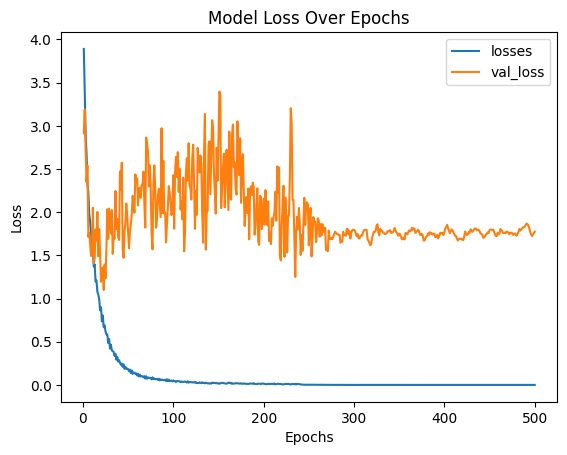

In [52]:
#plot vdf

import matplotlib.pyplot as plt

vdf.plot(x="epochs", y=["losses", "val_loss"],)
plt.title("Model Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

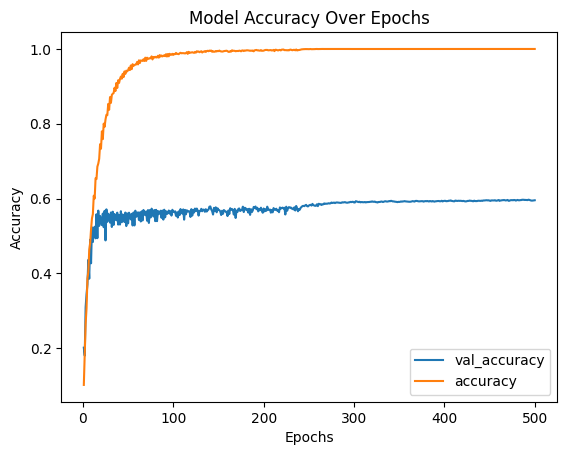

In [51]:
vdf.plot(x="epochs", y=["val_accuracy", "accuracy"],)
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()